#**Drive mount**

In [ ]:
from google.colab import drive
import shutil
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install pingouin

In [ ]:
import scipy.io
import pandas as pd
import os
import random

import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, SAGEConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp, global_add_pool as gaddp

import numpy as np
import pickle

import pingouin
from scipy import signal

## Loading first dataset (working memory)

In [ ]:
SUBJECTS_FOLDER = '/content/drive/MyDrive/Social memory cuing full dataset/derivatives/EEGPreprocessedDataTableStudy'
CURR_SUB = "sub-41"
SINGLE_SUBJECT = os.path.join(SUBJECTS_FOLDER, os.path.join(CURR_SUB, "ProcessedData/data_ica.mat"))
SUBJECTS = [ name for name in os.listdir(SUBJECTS_FOLDER) if os.path.isdir(os.path.join(SUBJECTS_FOLDER, name)) ]
SUBJECTS.sort()
DATA = "ProcessedData/data_ica.mat"

## Single subject data

In [ ]:
mat = scipy.io.loadmat(SINGLE_SUBJECT)
trial = mat['trial']
trialinfo = mat['trialinfo']

In [ ]:
channels = []
for channel in mat['label']:
  channels.append(channel[0][0])

channels_list = ['Fp1','Fpz','Fp2',
    'AF3','AF4',
    'F7','F3','Fz','F4','F8',
    'FC5','FC1','FC2','FC6',
    'C3','Cz','C4',
    'CP5','CP1','CP2','CP6',
    'P5','P3','Pz','P4','P6',
    'POz','O1','O2']

indexes = []
for ch in channels_list:
  indexes.append(channels.index(ch))

In [ ]:
trials = []
labels = []
trial = np.transpose(np.squeeze(trial))
for i, t in enumerate(trial):
  trials.append(t[indexes, 1250:1750])
  labels.append(trialinfo[i, 5]-1)  #zero is stick, one is avatar --- the -1 to have labels with 0 or 1 values (in dataset are 1 and 2)

trials = list(signal.decimate(np.transpose(trials, [0, 2, 1]), 4, axis = 1))
print(np.shape(trials))
print(np.shape(labels))

(224, 125, 29)
(224,)


## One channel EEG visualization

0
1


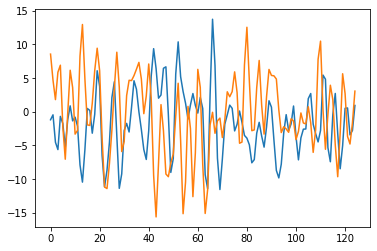

In [ ]:
import matplotlib.pyplot as plt

print(labels[0])
print(labels[150])

plt.plot(trials[0][:, 0])

plt.plot(trials[210][:, 0])

## Parameters

In [ ]:
NUM_EPOCHS = 400
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 34
VAL_BATCH_SIZE = 23
LEARNING_RATE = 0.00001
embedding_size = 150

FEATURES_TYPE = "adj"
SAVE_MODEL_VERSION = "1.0.0"
CURR_SWEEP_ID = 0
MODEL_TYPE = "SAGE_GL"
#CURR_DIR = "/content/drive/MyDrive/Tesi/Classification/GraphSAGE/" + CURR_SUB + "/sweep" + str(CURR_SWEEP_ID)
CURR_DIR = "/content/drive/MyDrive/Tesi/Classification+GL/HyperParamsTuning_" + MODEL_TYPE + "/" + CURR_SUB + "/sweep" + str(CURR_SWEEP_ID)

if not os.path.isdir(CURR_DIR):
  os.mkdir(CURR_DIR)

saved_models_dir =  CURR_DIR + SAVE_MODEL_VERSION

## Adjacency Matrix

In [ ]:
def edge_index_computation(trial_p):

  starts = []
  stops = []
  trial_df = pd.DataFrame(trial_p)

  corr_matrix = np.array(trial_df.pcorr())
  adj_matrix = np.round(np.abs(corr_matrix))

  for i in range(np.shape(adj_matrix)[0]):
    for j in range(np.shape(adj_matrix)[0]):
      if adj_matrix[i, j] == 1:
        starts.append(i)
        stops.append(j)

  edge_indices = [starts,stops]
  return edge_indices

def get_edges(trials):
  all_edges = []
  for trial in trials:
    all_edges.append(edge_index_computation(trial))

  return all_edges

In [ ]:
def zscore_normalization(train_data, val_data, train_labels, val_labels):
  resting_state_train_idxs = [i for i, j in enumerate(train_labels) if j == 3]
  resting_state_val_idxs = [i for i, j in enumerate(val_labels) if j == 3]

  resting_state_train = list(map(train_data.__getitem__, resting_state_train_idxs))
  resting_state_val = list(map(val_data.__getitem__, resting_state_val_idxs))

  rs_avg_train = np.mean(resting_state_train)
  rs_std_train = np.std(resting_state_train)

  rs_avg_val = np.mean(resting_state_val)
  rs_std_val = np.std(resting_state_val)

  train_data = normalize_trials(train_data, rs_avg_train, rs_std_train)
  val_data = normalize_trials(val_data, rs_avg_val, rs_std_val)

  return train_data, val_data


def normalize_trials(trials, avg, std):
  norm_trials = []
  for t in trials:
    norm_trials.append((t- avg)/std)

  return norm_trials

def normalize_list(lst):
  return (lst - np.mean(lst))/np.std(lst)

def _normalize_trial_by_channel(trial):
  
  for i in range(22):
    ch_avg = np.mean(trial[:, i])
    ch_std = np.std(trial[:, i])
    trial[:, i] = (trial[:, i] - ch_avg)/ch_std

  return trial

def _normalize_trial(trial):
  trial_avg = np.mean(trial)
  trial_std = np.std(trial)

  trial = (trial - trial_avg)/trial_std
  return trial

In [ ]:
#Node features are composed by the entries of the node's corresponding row in the correlation matrix

def adj_features(trial):
  feat = []
  trial_df = pd.DataFrame(trial, columns=mat['label'][indexes])
  corr_matrix = np.array(trial_df.corr())

  corr_matrix = _normalize_trial(corr_matrix)

  for i in range(np.shape(corr_matrix)[0]):
    feat.append(list(np.squeeze(corr_matrix[i, :])))

  return feat

def svd_features(trial):
  feat = []
  trial_df = pd.DataFrame(trial, columns=mat['label'][indexes])
  corr_matrix = np.array(trial_df.corr())
  
  u, s, v = scipy.linalg.svd(corr_matrix)
  u = _normalize_trial(u)


  for i in range(np.shape(u)[0]):
    feat.append(list(np.squeeze(u[i, :])))

  return feat

def get_features(trials, feats_type = "adj"):
  all_feats = []
  for trial in trials:
    if feats_type == "adj":
      all_feats.append(adj_features(trial))
    elif feats_type == "plv":
      all_feats.append(plv_features(trial))
    elif feats_type == "adj+plv":
      adj = adj_features(trial)
      plv = plv_features(trial)
      feat = adj+plv 
      all_feats.append(feat)
    else:
      all_feats.append(svd_features(trial))

  if feats_type == "adj+plv":
    all_feats = np.transpose(all_feats, [0, 2, 1])
  return all_feats

In [ ]:
from torch.utils.data import Dataset
from torch_geometric.data import Data

class EEG_dataset(Dataset):

    def __init__(self, trials, labels):
        self.trials = trials
        self.labels = labels
        self.features = get_features(trials, FEATURES_TYPE)
        self.edges = get_edges(trials)
    
    def __len__(self):
      return len(self.trials)

    def __getitem__(self, idx):
        return Data(x = torch.tensor(self.features[idx]),
                    edge_index = torch.tensor(self.edges[idx]),
                    y = torch.tensor(self.labels[idx], dtype = torch.long))

## Fixed split

In [ ]:
trials_0 = trials[:112]
trials_1 = trials[112:]

labels_0 = labels[:112]
labels_1 = labels[112:]

train_data_0 = trials_0[:83]
test_data_0 = trials_0[83:100]
val_data_0 = trials_0[100:]

train_data_1 = trials_1[:84]
test_data_1 = trials_1[84:101]
val_data_1 = trials_1[101:]

train_labels_0 = labels_0[:83]
test_labels_0 = labels_0[83:100]
val_labels_0 = labels_0[100:]

train_labels_1 = labels_1[:84]
test_labels_1 = labels_1[84:101]
val_labels_1 = labels_1[101:]

train_data = train_data_0 + train_data_1
val_data = val_data_0 + val_data_1
test_data = test_data_0 + test_data_1

train_labels = train_labels_0 + train_labels_1
val_labels = val_labels_0 + val_labels_1
test_labels = test_labels_0 + test_labels_1

print(np.shape(train_data))
print(np.shape(val_data))
print(np.shape(test_data))

print(val_labels.count(1)/len(val_labels))
print(test_labels.count(1)/len(test_labels))
print(train_labels.count(1)/len(train_labels))

## Random split

In [ ]:
from sklearn.model_selection import train_test_split

seed = random.random()
random.seed(seed)
random.shuffle(trials)
random.seed(seed)
random.shuffle(labels)

train_val_data = trials[:int(0.85*224)]
test_data = trials[int(0.85*224):]

train_val_labels = labels[:int(0.85*224)]
test_labels = labels[int(0.85*224):]

train_data, val_data, train_labels, val_labels = train_test_split(train_val_data, train_val_labels, test_size=0.12)

print(np.shape(train_data))
print(np.shape(val_data))
print(np.shape(test_data))

# Show val dataset imbalance

print(val_labels.count(1)/len(val_labels))
print(test_labels.count(1)/len(test_labels))
print(train_labels.count(1)/len(train_labels))

(167, 125, 29)
(23, 125, 29)
(34, 125, 29)
0.4782608695652174
0.5
0.5029940119760479


In [ ]:
train_dataset = EEG_dataset(train_data, train_labels)
val_dataset = EEG_dataset(val_data, val_labels)
test_dataset = EEG_dataset(test_data, test_labels)

print(next(iter(train_dataset)))
print(next(iter(val_dataset)))
print(next(iter(test_dataset)))

Data(x=[29, 29], edge_index=[2, 121], y=0)
Data(x=[29, 29], edge_index=[2, 143], y=0)
Data(x=[29, 29], edge_index=[2, 97], y=1)


# DataLoaders

In [ ]:
from torch_geometric.loader import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size= TRAIN_BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE)

print(next(iter(train_dataloader)))
print(next(iter(val_dataloader)))
print(next(iter(test_dataloader)))

DataBatch(x=[1856, 29], edge_index=[2, 9254], y=[64], batch=[1856], ptr=[65])
DataBatch(x=[667, 29], edge_index=[2, 3387], y=[23], batch=[667], ptr=[24])
DataBatch(x=[986, 29], edge_index=[2, 4580], y=[34], batch=[986], ptr=[35])


## Graph Learning layer (reference paper [link](https://www.ijcai.org/proceedings/2020/0184.pdf))

In [ ]:
class Graph_Learn(torch.nn.Module):
    '''
    Graph structure learning (based on the middle time slice)
    --------
    Input:  (batch_size, num_of_timesteps, num_of_vertices, num_of_features)
    Output: (batch_size, num_of_vertices, num_of_vertices)
    '''
    def __init__(self, alpha, **kwargs):
        super(Graph_Learn, self).__init__(**kwargs)
        self.alpha = alpha
        self.S = torch.Tensor([[[0.0]]])  # similar to placeholder
        self.diff = torch.Tensor([[[[0.0]]]])  # similar to placeholder
        a = torch.empty((29, 1), dtype = torch.double)
        a = torch.nn.init.uniform_(a, -0.05, 0.05)
        self.weight = torch.nn.Parameter(a)

    def forward(self, x):
        #Input:  [N, timesteps, vertices, features]
        N, T, V, F = x.size()
        
        # shape: (N,V,F) use the current slice (middle one slice)
        x = x[:,0,:,:]

        # shape: (N,V,V,F)
        diff = torch.permute(torch.permute(torch.broadcast_to(x,[V,N,V,F]), dims=(2,1,0,3))-x, dims=(1,0,2,3))

        # shape: (N,V,V)
        tmpS = torch.exp(torch.relu(torch.reshape(torch.matmul(torch.abs(diff).to(torch.double), self.weight), [N,V,V])))

        S = tmpS / torch.sum(tmpS,dim=1,keepdim=True)
        self.diff = diff
        self.S = S
        return S, diff, self.alpha

#Models definition

## Graph SAGE

In [ ]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, dropout, embedding_size, linear_size, linear_size2, num_conv, alpha):
        super(GraphSAGE, self).__init__()
        self.initial_conv = SAGEConv(29, embedding_size, aggr = 'mean')
        self.convs = torch.nn.ModuleList()
        for i in range(num_conv):
          self.convs.append(SAGEConv(embedding_size, embedding_size, aggr = 'mean'))

        self.drop = torch.nn.Dropout(dropout)
        self.relu = torch.nn.ReLU()

        #Multi-layer Perceptron
        self.out1 = Linear(embedding_size, linear_size)
        self.out2 = Linear(linear_size, linear_size2)
        self.out3 = Linear(linear_size2, 1)

        self.gl = Graph_Learn(alpha)

    def extract_edges(self, m):
      starts, stops = [], []
      avg_m = torch.mean(torch.abs(m))
      adj_matrices = torch.where(m > avg_m, m, 0.)  #treshold for matrix binarization imposed to corr matrix avg

      #adj_matrices = torch.round(m)
      for k in range(adj_matrices.size(dim = 0)):
        for i in range(adj_matrices.size(dim = 1)):
          for j in range(adj_matrices.size(dim = 1)):
            if adj_matrices[k, i, j] != 0:
              if not(k == 0):
                starts.append(i+ k*29)
                stops.append(j+ k*29)
              else:
                starts.append(i)
                stops.append(j)

      return torch.tensor([starts,stops], dtype = torch.long)

    def forward(self, x, edge_index, batch_index):
        x_gl = torch.unsqueeze(torch.reshape(x, (int(x.size(dim = 0)/29), 29, 29)), 1)
        S, diff, alpha = self.gl(x_gl)
        edge_index = self.extract_edges(S)

        x = self.initial_conv(x, edge_index)
        x = self.relu(x)
        
        #Graph convolutions
        for conv in self.convs:
          x = conv(x, edge_index)
          x = self.relu(x)

        #Global add pooling (tunable)
        hidden = gaddp(x, batch_index)

        #Multi-layer Perceptron
        hidden = self.out1(hidden)
        hidden = self.drop(hidden)
        
        hidden = self.out2(hidden)
        hidden = self.drop(hidden)
        
        hidden = self.out3(hidden)
        out = self.drop(hidden)
        
        out = torch.squeeze(out, dim = 1)
        out = torch.sigmoid(out)

        return out, hidden, S, diff, alpha

#model = GraphSAGE()
#print(model)
#print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

## GCN

In [ ]:
embedding_size = 400
embedding_size2 = 200
embedding_size3 = 100

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        #torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(29, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)
        self.drop1 = torch.nn.Dropout(0.2)
        self.relu = torch.nn.ReLU()

        # Output layer
        self.out = Linear(embedding_size, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = torch.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = torch.tanh(hidden)

        hidden = self.conv2(hidden, edge_index)
        hidden = torch.tanh(hidden)

        hidden = self.conv3(hidden, edge_index)
        hidden = torch.tanh(hidden)

        '''
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)
        '''
        
        hidden = gap(hidden, batch_index)
        # Apply a final (linear) classifier.
        out = self.out(hidden)
        out = self.drop1(out)
        out = torch.squeeze(out, dim = 1)
        out = torch.sigmoid(out)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(29, 400)
  (conv1): GCNConv(400, 400)
  (conv2): GCNConv(400, 400)
  (conv3): GCNConv(400, 400)
  (drop1): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (out): Linear(in_features=400, out_features=1, bias=True)
)
Number of parameters:  493601


#Training/testing phase

## WanDB

In [ ]:
!pip install wandb
import wandb
wandb.login()

In [ ]:
run = wandb.init(
    project = "Tesi", 
    entity = "lorenzo_mattia",
    name = 'classification/'+ MODEL_TYPE +'_'+ CURR_SUB + 'sweep_' + SAVE_MODEL_VERSION,
    group = 'classification_workMem_encoding_paramsTuning_' + CURR_SUB,
    job_type = 'training',
    save_code = True,
    magic = True,
    config = {
        "EPOCHS": NUM_EPOCHS,
        "LEARNING_RATE": LEARNING_RATE,
        "MODEL_TYPE": MODEL_TYPE,
        "TRAIN_BATCH_SIZE": TRAIN_BATCH_SIZE,
        "VAL_BATCH_SIZE": VAL_BATCH_SIZE,
        "TEST_BATCH_SIZE": TEST_BATCH_SIZE,
        "SAVED_MODEL_VERSION": SAVE_MODEL_VERSION,
        "EMBEDDING_SIZE": embedding_size,
        "FEATURES_TYPE": FEATURES_TYPE
    }
)

In [ ]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'best_val_loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'dropout': {
          'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
        },
    'embedding_size': {
          'values': [10, 15, 25, 50, 100, 150, 200]
        },
    'linear_size': {
          'values': [200, 150 ,100, 64, 32]
        },
    'linear_size2': {
          'values': [100, 64, 32, 16, 8, 4]
        },
    'num_convs': {
          'values': [1, 2, 3]
    },
    'momentum': {
        'distribution': 'uniform',
        'min': 0.9,
        'max': 1.0
    },
    'alpha': {
        'distribution': 'uniform',
        'min': 0.000001,
        'max': 0.1
    }
        
}

sweep_config['parameters'] = parameters_dict

sweep_id = wandb.sweep(sweep_config, project="Tesi")

Create sweep with ID: rxydb4sl
Sweep URL: https://wandb.ai/lorenzo_mattia/Tesi/sweeps/rxydb4sl


## Test during hyperparamters optimization

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

loss_fn = torch.nn.BCELoss()
def short_test(model):
  preds = []
  lbls = []
  for test_batch in test_dataloader:
    with torch.no_grad():
        model.eval()
        pred, embedding, S, diff, alpha = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    loss = loss_fn(pred, test_batch.y.float())
    preds.append(torch.round(pred).tolist())
    lbls.append(test_batch.y.tolist())

  preds = [x for xs in preds for x in xs]
  lbls = [x for xs in lbls for x in xs]
  indexes_non_soc = torch.tensor([i for i,val in enumerate(lbls) if val==0])
  indexes_soc = torch.tensor([i for i,val in enumerate(lbls) if val==1])

  acc = accuracy_score(lbls, preds)

  temp2 = torch.reshape(S, (TEST_BATCH_SIZE, 29, 29))

  learned_non_soc = torch.mean(torch.index_select(temp2, dim = 0, index = indexes_non_soc), dim = 0)
  learned_soc = torch.mean(torch.index_select(temp2, dim = 0, index = indexes_soc), dim = 0)

  print("Average learned adjacency mat non soc")
  plt.imshow(learned_non_soc)
  #plt.savefig(CURR_DIR + LOAD_MODEL_VERSION + "/Average learned adjacency mat non soc.png")
  plt.show()
  #torch.save(learned_non_soc, CURR_DIR + LOAD_MODEL_VERSION + '/learned_non_soc.pt') 
  
  print("Average learned adjacency mat soc")
  plt.imshow(learned_soc)
  #plt.savefig(CURR_DIR + LOAD_MODEL_VERSION + "/Average learned adjacency mat soc.png")
  plt.show()
  #torch.save(learned_soc, CURR_DIR + LOAD_MODEL_VERSION + '/learned_soc.pt') 

  return acc, loss
  #print(classification_report(lbls, preds, target_names=["stick", "avatar"]))

## Hyperparameters optimization

In [ ]:
def diff_loss(diff, S):
    '''
    compute the 1st loss of L_{graph_learning}
    '''
    
    if len(S.shape)==3:
        # batch input
        return torch.mean(torch.sum(torch.sum(diff**2,dim=3, dtype = torch.double)*S, dim=(1,2)))
    else:
        return torch.sum(torch.sum(diff**2,dim=2)*S)


def F_norm_loss(S, Falpha):
    '''
    compute the 2nd loss of L_{graph_learning}
    '''
    if len(S.shape)==3:
        # batch input
        return Falpha * torch.sum(torch.mean(S**2,axis=0))
    else:
        return Falpha * torch.sum(S**2)

In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms
#best_loss = 10000
loss_fn = torch.nn.BCELoss()
sweep_code = 0
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def build_network(dropout, embedding_size, linear_size, linear_size2, num_convs, alpha):
    network = GraphSAGE(dropout, embedding_size, linear_size, linear_size2, num_convs, alpha)

    return network

def build_optimizer(network, optimizer, learning_rate, mom):
    if optimizer == "rmsprop":
        optimizer = optim.RMSprop(network.parameters(),
                              lr=learning_rate)
    elif optimizer == "adam":
        optimizer = optim.Adam(network.parameters(),
                               lr=learning_rate)
    elif optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                               lr=learning_rate, momentum = mom)

    return optimizer

def train_epoch(model, train_dataloader, val_dataloader, optimizer, best_loss = 10000):
  model.train()
  n, d, n_v, d_v = 0, 0, 0, 0
  model.train()
  for batch in train_dataloader:

      optimizer.zero_grad()
      pred, embedding, S, diff, alpha = model(batch.x.float(), batch.edge_index, batch.batch)
      #train_loss = loss_fn(pred, batch.y.float())
      train_diff_l = diff_loss(diff, S)
      train_F_norm_l = F_norm_loss(S, alpha)
      train_l = loss_fn(pred, batch.y.float())
      train_loss =  train_l  + train_diff_l + train_F_norm_l

      pred = torch.round(pred)
      d += pred.shape[0]
      n += (batch.y.float() == pred).int().sum()

      train_loss.backward()
      optimizer.step()
  model.train(False)
  for batch in val_dataloader:
    #model.eval()          #check
    with torch.no_grad():
      pred, embedding, S, diff, alpha = model(batch.x.float(), batch.edge_index, batch.batch) 
    
    val_diff_l = diff_loss(diff, S)
    val_F_norm_l = F_norm_loss(S, alpha)
    val_l = loss_fn(pred, batch.y.float())

    val_loss =  val_l  + val_diff_l + val_F_norm_l
    #val_loss = loss_fn(pred, batch.y.float())
    pred = torch.round(pred)
    d_v += pred.shape[0]
    n_v += (batch.y.float() == pred).int().sum()
    
  #print("Train loss: " + str(round(train_loss.item(), 3)) + " Train accuracy: " + str(round((n / d).item(), 3)) +\
  #      " Val loss: " + str(round(val_loss.item(), 3)) + " Val accuracy: " + str(round((n_v / d_v).item(), 3)))
  
  if best_loss > val_loss:
    best_loss = val_loss
    #if not os.path.isdir(saved_models_dir):
      #os.mkdir(saved_models_dir)
    torch.save(model.state_dict(), CURR_DIR + "/best_model")

  wandb.log({
    'Train loss': train_loss,
    'Train diff loss': train_diff_l,
    'Train classification loss': train_l,
    'Train F_norm loss': train_F_norm_l,
    'Val loss': train_loss,
    'Val diff loss': val_diff_l,
    'Val classification loss': val_l,
    'Val F_norm loss': val_F_norm_l,
    'Train acc': n/d,
    'Val acc': n_v/d_v,
    'best_val_loss': best_loss,
  })

  return train_loss.item(), val_loss.item(), (n / d).item(), (n_v / d_v).item(), best_loss

def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        #loader = build_dataset(config.batch_size)
        network = build_network(config.dropout, config.embedding_size, config.linear_size, config.linear_size2, config.num_convs, config.alpha)
        optimizer = optim.Adam(network.parameters(), lr=0.001)
        best_loss = 10000
        for epoch in range(75):
            train_loss, val_loss, train_acc, val_acc, best_loss = train_epoch(network, train_dataloader, val_dataloader, optimizer, best_loss)
        
        global sweep_code
        os.mkdir(CURR_DIR + "/" + str(sweep_code))
        os.replace(CURR_DIR + "/best_model", CURR_DIR + "/" + str(sweep_code) + "/best_model")

        network.load_state_dict(torch.load(CURR_DIR + "/" + str(sweep_code) + "/best_model"))
        acc, test_loss = short_test(network)
        wandb.log({"test_accuracy": acc,
                   "test_loss": test_loss})
        sweep_code = sweep_code + 1

wandb: Agent Starting Run: 8b8xyn1n with config:
wandb: 	alpha: 0.07901023468026193
wandb: 	dropout: 0.1
wandb: 	embedding_size: 200
wandb: 	linear_size: 200
wandb: 	linear_size2: 16
wandb: 	momentum: 0.9418081999526192
wandb: 	num_convs: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Average learned adjacency mat non soc


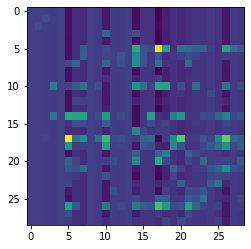

Average learned adjacency mat soc


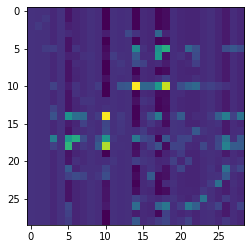

Train F_norm loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂
Train acc,▁▂▂▃▁▂▄▅▅▅▆▆▆▇▆▇▇█▅▇▆▇▇██████▇▇▇▇▇██▇██▇
Train classification loss,█▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
Train diff loss,█▄▃▃▇▅▆▄▅▅▆▇▁▃▆▄▆▆▇▄▅▄▄▅█▃▅▆▄▄▅▆▃▅▄▄▄▄▇▄
Train loss,█▄▃▃▇▅▆▄▅▅▆▇▁▃▆▄▆▆▇▄▅▄▄▅█▃▅▆▄▄▅▆▃▅▄▄▄▄▇▄
Val F_norm loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃
Val acc,▂▁▂▄▁▅▅▆▆█▆▆▆▆▄▄▅▃▄▄▄▄▃▄▅▅▅▅▅▄▆▄▇▇▇▆▅▆▆▆
Val classification loss,▂▃▂▂▂▂▂▂▂▁▂▁▂▁▃▃▂▂▂▅▂▃▂▃▃▂▃▂▃█▃▄▁▁▁▁▂▂▃▂
Val diff loss,█▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Val loss,█▄▃▃▇▅▆▄▅▅▆▇▁▃▆▄▆▆▇▄▅▄▄▅█▃▅▆▄▄▅▆▃▅▄▄▄▄▇▄
best_val_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: o1uyj4sh with config:
wandb: 	alpha: 0.012189888799220635
wandb: 	dropout: 0.1
wandb: 	embedding_size: 50
wandb: 	linear_size: 64
wandb: 	linear_size2: 32
wandb: 	momentum: 0.9636505822639498
wandb: 	num_convs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Average learned adjacency mat non soc


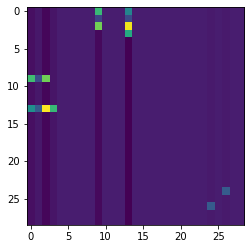

Average learned adjacency mat soc


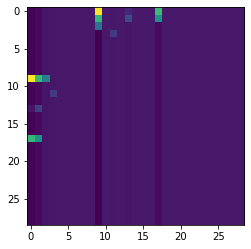

Train F_norm loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train acc,▁▂▂▂▃▂▂▃▄▄▄▅▅▆▆▇▆▇▆█▇▇█████████▆▇█▇▇████
Train classification loss,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁▁▁▁▁
Train diff loss,██▇▅▆▆▅▄▇▄▂▆▆▃▅▄▅▆▆▆▄▄▅▄▇▆▇▁▅▅▃▄▆▅▄▄▄▅▃▆
Train loss,██▇▅▆▆▅▄▇▄▂▆▆▃▅▄▅▆▆▆▄▄▅▄▇▆▇▁▅▅▄▄▆▅▄▄▄▅▃▆
Val F_norm loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val acc,▁▁▂▁▃▅▃▆▄▅▆▆▅▅▆▅▅▅▅▅▅▆▆▅▅▆▇▆▆▆▂▆▇▇█▇██▇▇
Val classification loss,▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▂▃▆▅█▅▃▆▂▃▄▃▃▄
Val diff loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val loss,██▇▅▆▆▅▄▇▄▂▆▆▃▅▄▅▆▆▆▄▄▅▄▇▆▇▁▅▅▄▄▆▅▄▄▄▅▃▆
best_val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: 4ycm8hey with config:
wandb: 	alpha: 0.07165657809400913
wandb: 	dropout: 0.3
wandb: 	embedding_size: 150
wandb: 	linear_size: 200
wandb: 	linear_size2: 100
wandb: 	momentum: 0.964871373293231
wandb: 	num_convs: 2
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Average learned adjacency mat non soc


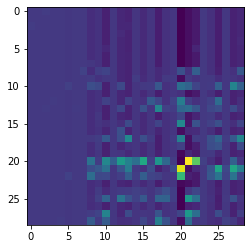

Average learned adjacency mat soc


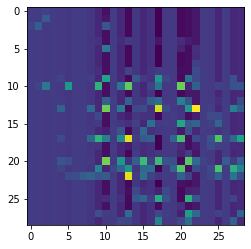

Train F_norm loss,▁▁▁▁▂▁▁▂▂▂▂▂▂▃▂▂▂▃▃▃▃▃▃▄▄▅▄▅▅▅▅▆▆█▅▇▇▇█▇
Train acc,▁▃▁▁▁▄▃▆▄▆▆▇▆▇▇▇▇▇▆▇▇▆▇▇▆▇▇▇▇▇▇▇▇█▇▇▇▇▇▇
Train classification loss,▇▅█▆▆▅▄▄▃▄▄▃▃▂▂▂▁▂▂▁▂▇▂▂▂▁▁▁▁▂▂▂▂▁▁▁▁▂▂▁
Train diff loss,▄▄▃▂▄▄▁█▅▄▃▂▅▇▆▇▂▃▅▃▂▄▅▆█▆▆▄▅▁█▃▄▇▃█▃▆▅▄
Train loss,▄▄▃▂▄▅▁█▅▄▃▂▅▇▆▇▂▃▅▃▂▄▅▆█▆▆▄▅▁█▃▄▇▃█▃▆▅▄
Val F_norm loss,▁▁▁▁▂▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▅▅▆▇▆▇▇▇██
Val acc,▃▁▁▃▃▄█▄▆▆██▄▃█▃▄▄▄▃▆██▆▄█▄▄██▄▆▆█▄▆▆▆▆▆
Val classification loss,▁▂▁▁▁▁▁▁▁▁▁▁▂▂▃▄▄▄▅▆█▅▄▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆
Val diff loss,▂▁▁▄▇▄▅▇▇▆▆█▆▇▇▆▆▇▇▆▆▆▆▅▄▅▅▄▄▅▄▃▃▄▂▃▃▂▂▂
Val loss,▄▄▃▂▄▅▁█▅▄▃▂▅▇▆▇▂▃▅▃▂▄▅▆█▆▆▄▅▁█▃▄▇▃█▃▆▅▄
best_val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: b8kird55 with config:
wandb: 	alpha: 0.06231157336856466
wandb: 	dropout: 0.3
wandb: 	embedding_size: 25
wandb: 	linear_size: 200
wandb: 	linear_size2: 64
wandb: 	momentum: 0.9306458561108208
wandb: 	num_convs: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Average learned adjacency mat non soc


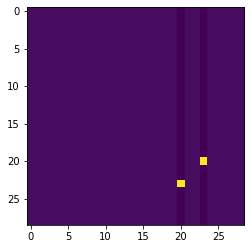

Average learned adjacency mat soc


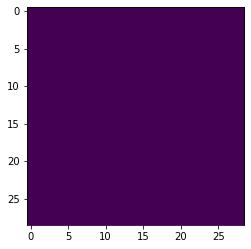

Train F_norm loss,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train acc,▂▁▁▁▂▂▂▄▃▄▃▃▄▂▄▆▅▄▅▇▆▆▆▆▇▆▆▇▇▆█▇▇██▇▇▇▇▇
Train classification loss,▇█▆▆▆▆▇▆▆▆▆▅▅▆▅▅▄▅▄▄▃▄▄▃▃▃▂▃▃▂▂▂▃▂▁▃▁▂▁▂
Train diff loss,█▆▃▃▃▂▂▃▂▃▃▃▃▂▃▃▃▃▃▃▂▃▃▃▃▂▁▃▂▂▂▃▃▂▂▃▂▃▃▃
Train loss,█▆▃▃▃▂▂▃▂▃▃▃▃▂▃▃▃▃▃▃▂▃▃▃▃▂▁▃▂▂▂▃▃▂▂▃▁▃▃▃
Val F_norm loss,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val acc,▄▁▂▂▄▆▆▃▅▅▄▇▆▇▇▇▇▇▇▆▅▆▇▅▅▆▅▅▅▅▅▅▄▅▅██▅▅▇
Val classification loss,▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▁▂▂▂▁▁▁▂▁▂▄▄▃▃▆▄▅▇▃▃▇█▃
Val diff loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val loss,█▆▃▃▃▂▂▃▂▃▃▃▃▂▃▃▃▃▃▃▂▃▃▃▃▂▁▃▂▂▂▃▃▂▂▃▁▃▃▃
best_val_loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: tqer9q6z with config:
wandb: 	alpha: 0.09536765314495828
wandb: 	dropout: 0
wandb: 	embedding_size: 100
wandb: 	linear_size: 64
wandb: 	linear_size2: 32
wandb: 	momentum: 0.9554537183720136
wandb: 	num_convs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Average learned adjacency mat non soc


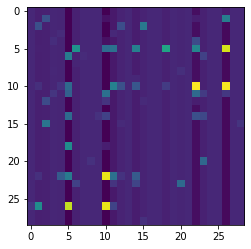

Average learned adjacency mat soc


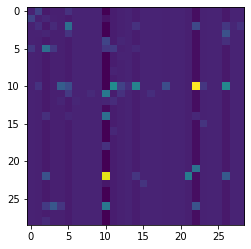

Train F_norm loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▂▂▂▂▃▂▄▃▄▄▄▅▅▆▅▆▇██
Train acc,▁▂▁▁▁▃▃▄▅▅▆▆▅▇▇▇▇▇██████████████████████
Train classification loss,█▇▇▇▇▇▇▇▆▅▃▃▃▃▃▂▃▃▂▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train diff loss,▆▄▃▃█▅▆▇▂▆▅▁▆▆▆▄▇▆▁▅▃▄▆▆▆▄▄▅▃▇▄▅▅▅▆▃▅▆▄▂
Train loss,▆▄▃▃█▅▆▇▃▆▅▁▆▆▆▄▇▆▁▅▃▄▆▆▆▄▄▅▃▆▄▅▅▅▆▃▅▆▄▂
Val F_norm loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▃▄▅▅▅▆▆▇▆█▇█
Val acc,▁▂▂▁▄▂▄▅▂▄▅▄█▅█▄████▂▄▂▇▅▅▂▅▅▄▅▄▅▅▄▇▄▇▅▅
Val classification loss,▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▂▂▂▂▂▂▂▃▂▂▃▃▃▃▃▄▄▄▄█▄▄▄▄
Val diff loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▂▃▄▃▄▄▅▅▅▅▆▇▇▇█▇█
Val loss,▆▄▃▃█▅▆▇▃▆▅▁▆▆▆▄▇▆▁▅▃▄▆▆▆▄▄▅▃▆▄▅▅▅▆▃▅▆▄▂
best_val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: 02sg6lyk with config:
wandb: 	alpha: 0.09098123691488988
wandb: 	dropout: 0.2
wandb: 	embedding_size: 10
wandb: 	linear_size: 150
wandb: 	linear_size2: 8
wandb: 	momentum: 0.9569300924175096
wandb: 	num_convs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
wandb.agent(sweep_id, train, count=10)

## Normal training (No optimization)

In [ ]:
def training_loop(model, optimizer):
  train_acc, val_acc, ep, train_losses, val_losses = [], [], [], [], []
  best_acc = 0
  best_loss = 10000
  for epoch in range(NUM_EPOCHS):
      model.train()
      ep.append(epoch)
      n, d, n_v, d_v = 0, 0, 0, 0

      for batch in train_dataloader:
 
          optimizer.zero_grad()
          pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
          train_loss = loss_fn(pred, batch.y.float())

          pred = torch.round(pred)
          d += pred.shape[0]
          n += (batch.y.float() == pred).int().sum()

          train_loss.backward()
          optimizer.step()
      
      for batch in val_dataloader:
        #model.eval()          #check
        with torch.no_grad():
          pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
        
        val_loss = loss_fn(pred, batch.y.float())
        pred = torch.round(pred)
        d_v += pred.shape[0]
        n_v += (batch.y.float() == pred).int().sum()
        
      print("Epoch: " + str(epoch) + " Train loss: " + str(round(train_loss.item(), 3)) + " Train accuracy: " + str(round((n / d).item(), 3)) +\
            " Val loss: " + str(round(val_loss.item(), 3)) + " Val accuracy: " + str(round((n_v / d_v).item(), 3)))

        
      cur_acc = (n_v / d_v).item()

      train_acc.append((n / d).item())
      val_acc.append((n_v / d_v).item())
      train_losses.append(train_loss.item())
      val_losses.append(val_loss.item())

      if best_loss > val_losses[-1]:
        best_loss = val_losses[-1]
        if not os.path.isdir(saved_models_dir):
          os.mkdir(saved_models_dir)
        torch.save(model.state_dict(), saved_models_dir + "/best_model")

      wandb.log({
        'Train loss': train_losses[-1],
        'Val loss': val_losses[-1],
        'Train acc': train_acc[-1],
        'Val acc': val_acc[-1]
      })
      
  return train_acc, val_acc, ep, train_losses, val_losses

In [ ]:
model = GraphSAGE()
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)
train_acc, val_acc, ep, train_losses, val_losses = training_loop(model, optimizer)

Epoch: 0 Train loss: 0.727 Train accuracy: 0.539 Val loss: 0.691 Val accuracy: 0.609
Epoch: 1 Train loss: 0.764 Train accuracy: 0.599 Val loss: 0.67 Val accuracy: 0.696
Epoch: 2 Train loss: 0.775 Train accuracy: 0.563 Val loss: 0.654 Val accuracy: 0.565
Epoch: 3 Train loss: 0.762 Train accuracy: 0.599 Val loss: 0.561 Val accuracy: 0.652
Epoch: 4 Train loss: 0.734 Train accuracy: 0.533 Val loss: 0.627 Val accuracy: 0.652
Epoch: 5 Train loss: 0.688 Train accuracy: 0.587 Val loss: 0.542 Val accuracy: 0.652
Epoch: 6 Train loss: 0.631 Train accuracy: 0.599 Val loss: 0.568 Val accuracy: 0.652
Epoch: 7 Train loss: 0.697 Train accuracy: 0.617 Val loss: 0.696 Val accuracy: 0.435
Epoch: 8 Train loss: 0.676 Train accuracy: 0.605 Val loss: 0.454 Val accuracy: 0.826
Epoch: 9 Train loss: 0.626 Train accuracy: 0.599 Val loss: 0.658 Val accuracy: 0.522
Epoch: 10 Train loss: 0.522 Train accuracy: 0.653 Val loss: 0.58 Val accuracy: 0.696
Epoch: 11 Train loss: 0.69 Train accuracy: 0.617 Val loss: 0.586 V

In [ ]:
run.finish()

## Normal Test

In [ ]:
#LOAD_MODEL_VERSION = "1.0.0"
model = GraphSAGE(0.0, 10, 64, 100, 2, 0.0394)
num_sweep = 6
model.load_state_dict(torch.load(CURR_DIR + "/" + str(num_sweep) + "/best_model"))
model.eval()

GraphSAGE(
  (initial_conv): SAGEConv(29, 10, aggr=mean)
  (convs): ModuleList(
    (0): SAGEConv(10, 10, aggr=mean)
    (1): SAGEConv(10, 10, aggr=mean)
  )
  (drop): Dropout(p=0.0, inplace=False)
  (relu): ReLU()
  (out1): Linear(in_features=10, out_features=64, bias=True)
  (out2): Linear(in_features=64, out_features=100, bias=True)
  (out3): Linear(in_features=100, out_features=1, bias=True)
  (gl): Graph_Learn()
)

Average learned adjacency mat non soc


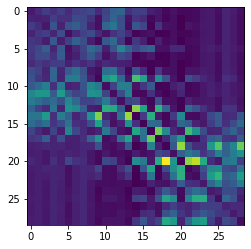

Average learned adjacency mat soc


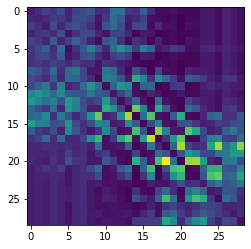

              precision    recall  f1-score   support

       stick       0.67      0.47      0.55        17
      avatar       0.59      0.76      0.67        17

    accuracy                           0.62        34
   macro avg       0.63      0.62      0.61        34
weighted avg       0.63      0.62      0.61        34



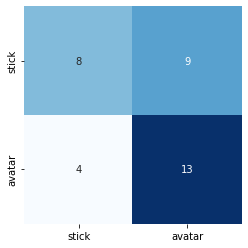

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def test(num_sweep):
  preds = []
  lbls = []
  for test_batch in test_dataloader:
    with torch.no_grad():
        #model.eval()
     pred, embedding, S, diff, alpha = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    preds.append(torch.round(pred).tolist())
    lbls.append(test_batch.y.tolist())

  preds = [x for xs in preds for x in xs]
  lbls = [x for xs in lbls for x in xs]
  indexes_non_soc = torch.tensor([i for i,val in enumerate(lbls) if val==0])
  indexes_soc = torch.tensor([i for i,val in enumerate(lbls) if val==1])

  temp2 = torch.reshape(S, (TEST_BATCH_SIZE, 29, 29))

  learned_non_soc = torch.mean(torch.index_select(temp2, dim = 0, index = indexes_non_soc), dim = 0)
  learned_soc = torch.mean(torch.index_select(temp2, dim = 0, index = indexes_soc), dim = 0)

  print("Average learned adjacency mat non soc")
  plt.imshow(learned_non_soc)
  plt.savefig(CURR_DIR + "/" + str(num_sweep) + "/Average learned adjacency mat non soc.png")
  plt.show()
  torch.save(learned_non_soc, CURR_DIR + "/" + str(num_sweep) + '/learned_non_soc.pt') 
  
  print("Average learned adjacency mat soc")
  plt.imshow(learned_soc)
  plt.savefig(CURR_DIR + "/" + str(num_sweep) + "/Average learned adjacency mat soc.png")
  plt.show()
  torch.save(learned_soc, CURR_DIR + "/" + str(num_sweep) + '/learned_soc.pt') 

  conf_mat = confusion_matrix(lbls, preds)
  conf_mat = sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', \
                        cbar=False, xticklabels = ["stick", "avatar"], yticklabels = ["stick", "avatar"])

  SAVE = True

  if SAVE:
    conf_mat.figure.savefig(CURR_DIR + "/" + str(num_sweep) + "/confusion_matrix.png")



  print(classification_report(lbls, preds, target_names=["stick", "avatar"]))

test(num_sweep)